In [1]:
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

## Import Fluxes

## Upscaling of Biomass Growth Time-Series

In [2]:
# Number of time steps and features to extract
#file_path = '/mnt/data/high_losing_42_11_1xscale.h5'
import h5py
import cv2

base_dir = '/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/'
f_dir = os.listdir(base_dir)
h5_files = []
h5_files_train = []

# Iterate over all files in the directory
for filename in f_dir:
    if (filename.endswith(".h5")) & ((("2x" in filename))):
        h5_files_train.append(base_dir+filename)
#     if (filename.endswith(".h5")) & (("8x" in filename)):
#         if (("10_5" not in filename) & ("20_20" not in filename)):
#             h5_files_train.append(base_dir+filename)
    if (filename.endswith(".h5")) & ((("10x" in filename))):
#         if (("10_5" in filename) | ("20_20" in filename)):
        h5_files.append(base_dir+filename)
# Run the processing in parallel
h5_files_train =  sorted(
    h5_files_train,
    key=lambda x: tuple(map(int, x.split('high_losing_')[1].split('_')[:2]))
)
h5_files =  sorted(
    h5_files,
    key=lambda x: tuple(map(int, x.split('high_losing_')[1].split('_')[:2]))
)

h5_files = h5_files[0:6]
h5_files_train = h5_files_train[0:6]
hdf5_file = h5py.File(h5_files[0], 'r')
# Fetching the first five time steps
time_steps = sorted(list(hdf5_file.keys()))

# Inspecting the features present in each of these time steps
features_per_time_step = {time_step: list(hdf5_file[time_step].keys()) for time_step in time_steps}


num_time_steps = 115
num_features = 9  # As observed from the dataset

# Initialize the final array with the desired shape [5, 100, 200, 19]
y = np.zeros((len(h5_files),num_time_steps-1, 100, 2000, num_features))

# Extracting and reshaping data from the first five time steps
for i in range(len(h5_files)):
    hdf5_file = h5py.File(h5_files[i], 'r')
    for t_idx, time_step in enumerate(time_steps[2:]):  # Skipping the first two non-time-step groups
        count=0
        for f_idx, feature in enumerate(features_per_time_step[time_step]):
            if ('O2' not in feature)& ('Perm' not in feature)& ('Material' not in feature)& ('Sat' not in feature)& ('Z' not in feature)& ('biocide' not in feature)& ('ethanol' not in feature)& ('Chubbite' not in feature):
                dataset = hdf5_file[time_step][feature]
                y[i, t_idx, :, :, count] = dataset[:, :, 0]#cv2.resize(dataset[:, :, 0], [500,50])  # Reshape and assign
                count = count+1

# Checking the shape of the extracted data array
y.shape


x = np.zeros((len(h5_files_train),num_time_steps-1, 100, 400, num_features))

# Extracting and reshaping data from the first five time steps
for i in range(len(h5_files_train)):
    hdf5_file = h5py.File(h5_files_train[i], 'r')
    for t_idx, time_step in enumerate(time_steps[2:]):  # Skipping the first two non-time-step groups
        count=0
        for f_idx, feature in enumerate(features_per_time_step[time_step]):
            if ('O2' not in feature)& ('Perm' not in feature)& ('Material' not in feature)& ('Sat' not in feature)& ('Z' not in feature)& ('biocide' not in feature)& ('ethanol' not in feature)& ('Chubbite' not in feature):
                dataset = hdf5_file[time_step][feature]
                x[i, t_idx, :, :, count] = dataset[:, :, 0]#cv2.resize(dataset[:, :, 0], [500,50])  # Reshape and assign
                count = count+1
# Open the HDF5 file and extract data to fit the specified shape [5, 100, 200, n]
#extracted_data_array[0]

In [3]:
### cv2.resize(dataset[:, :, 0], [50,500])
feature

'molasses_im [mol_m^3]'

In [4]:
field_names = [
    "Liquid X-Velocity [m_per_h]",
    "Liquid Y-Velocity [m_per_h]",
    "Liquid_Pressure [Pa]",
    #"Permeability_X [m^2]",
    "Porosity",
    "Temperature [C]",
    #"Total_CO2 [M]",
    "Total_Cr(VI) [M]",
    #"Total_O2 [M]",
    "Total_molasses [M]",
    "biomass [mol_m^3]",
    "molasses_im [mol_m^3]"
]

In [5]:
#n=7
#import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
#fig=plt.figure(figsize=(24,24), dpi=600)
#plt.imshow(y[2,100,:,:,n])#, norm=LogNorm())
#field_names[n]
#fig.savefig('label.png')  # Replace 'output.png' with your desired file path and format

#plt.colorbar()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class DoubleConv_down(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1, padding=0),
            #nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
            #nn.BatchNorm2d(200),
            nn.ReLU(inplace=True),
            #nn.Conv2d(200, out_channels, kernel_size=3, padding=1),
            #nn.BatchNorm2d(out_channels),
            #nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DoubleConv_up(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, 600, kernel_size=1, padding=0),
            #nn.BatchNorm2d(600),
            nn.ReLU(inplace=True),
            nn.Conv2d(600, 800, kernel_size=1, padding=0),
            #nn.BatchNorm2d(800),
            nn.ReLU(inplace=True),
            nn.Conv2d(800, out_channels, kernel_size=1, padding=0),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        #self.inc = DoubleConv_down(400, 256)
        self.up = DoubleConv_up(400, 1200)
        # Add more layers and upsampling layers to complete the U-Net structure

        self.outc = nn.Conv2d(1200, 2000, kernel_size=1)

    def forward(self, x):
        x = x[0,:,:,:,:].permute(0,2,1,3)
        #x = self.inc(x)
        x = self.up(x)
        # Implement forward pass with upsampling and concatenations
        logits = self.outc(x)
        return logits


class CustomDataset(Dataset):
    def __init__(self, x, target):
        """
        Args:
            data (numpy array): A numpy array of shape [N, 100, 200, 19] where N is the number of samples.
        """
        self.x = torch.tensor(x, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        input = self.x[idx]
        target = self.target[idx]
        return input, target

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, num_channels, reduction_ratio=2):
        """
        Initializes the ChannelAttention module.
        
        :param num_channels: Number of input channels.
        :param reduction_ratio: Reduction ratio for the hidden layer in MLP.
        """
        super(ChannelAttention, self).__init__()
        self.num_channels = num_channels
        self.reduction_ratio = reduction_ratio

        # Define the MLP layers
        self.mlp = nn.Sequential(
            nn.Linear(num_channels, num_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(num_channels // reduction_ratio, num_channels)
        )

    def forward(self, x):
        """
        Forward pass of the ChannelAttention module.
        
        :param x: Input tensor of shape (batch_size, num_channels, height, width).
        :return: Output tensor after applying channel attention.
        """
        # Global average pooling
        avg_pool = F.adaptive_avg_pool2d(x, (1, 1))
        avg_pool = avg_pool.view(avg_pool.shape[0], -1)

        # Channel attention
        attention = self.mlp(avg_pool)
        attention = torch.sigmoid(attention).view(attention.shape[0], attention.shape[1], 1, 1)

        # Scale the input by attention scores
        return x * attention

# Example of using the ChannelAttention module
# Assuming an input with 64 channels
channel_att = ChannelAttention(num_channels=64)
channel_att

ChannelAttention(
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
  )
)

In [8]:
class ConvUp(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)
        
class UNet1(nn.Module):
    def __init__(self, inc, outc):
        super(UNet1, self).__init__()
        self.up = ConvUp(inc, outc)
        self.att1 = ChannelAttention(num_channels=100)
        self.att2 = ChannelAttention(num_channels=outc)
    def forward(self, x):
        x = x[0,:,:,:,:]
        x = self.att1(x).permute(0,2,1,3)
        x = self.up(x)
        x = self.att2(x)
        return x

class UNet2(nn.Module):
    def __init__(self, inc, outc):
        super(UNet2, self).__init__()
        self.up = ConvUp(inc, outc)
        self.att1 = ChannelAttention(num_channels=100)
        self.att2 = ChannelAttention(num_channels=outc)
    def forward(self, x):
        x = x.permute(0,2,1,3)
        x = self.att1(x).permute(0,2,1,3)
        x = self.up(x)
        x = self.att2(x)
        return x


In [9]:
#n=7
#plt.figure(figsize=(24,24), dpi=100)
#plt.imshow(x[0,113,:,:,n])#, norm=LogNorm())
#field_names[n]
#np.min(x[2,113,:,:,n])
scales

NameError: name 'scales' is not defined

In [10]:
scales=[]
for i in range(x.shape[4]):
    xmin = np.min(x[:,:,:,:,i])
    xmax = np.max(x[:,:,:,:,i])
    x[:,:,:,:,i] = (x[:,:,:,:,i] - xmin)/(xmax-xmin)
    y[:,:,:,:,i] = (y[:,:,:,:,i] - xmin)/(xmax-xmin)
    scales.append([xmin,xmax])

scales


[[-3.8411125549317013, 597.4671440974266],
 [-615.1042997637863, 357.84820748247256],
 [0.0, 6822.169871757096],
 [0.0001, 0.6],
 [7.788525219135888, 15.024872883573318],
 [9.998195511764697e-21, 0.0021615209557147423],
 [9.992418077905442e-21, 0.00019222389277486797],
 [1e-10, 353.88041919640534],
 [9.999999999999992e-21, 4.945182939521276]]

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = UNet1(400, 2000).to(device)

#model2 = UNet2(400, 800).to(device)

#model3 = UNet2(800, 1200).to(device)

#model4 = UNet2(1200, 1600).to(device)

#model5 = UNet2(1600, 2000).to(device)
model1

UNet1(
  (up): ConvUp(
    (double_conv): Sequential(
      (0): Conv2d(400, 2000, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (att1): ChannelAttention(
    (mlp): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=100, bias=True)
    )
  )
  (att2): ChannelAttention(
    (mlp): Sequential(
      (0): Linear(in_features=2000, out_features=1000, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1000, out_features=2000, bias=True)
    )
  )
)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR


class CustomDataset(Dataset):
    def __init__(self, x, target):
        """
        Args:
            data (numpy array): A numpy array of shape [N, 100, 200, 19] where N is the number of samples.
        """
        self.x = torch.tensor(x, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        input = self.x[idx]
        target = self.target[idx]
        return input, target

#criterion3 = SmoothnessLoss(.1, .1)
dataset = CustomDataset(x, y)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#criterion1 = DivLoss()
criterion2 = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.002)
#optimizer2 = optim.Adam(model2.parameters(), lr=0.0004)
#optimizer3 = optim.Adam(model3.parameters(), lr=0.0004)
#optimizer4 = optim.Adam(model4.parameters(), lr=0.0004)
#optimizer5 = optim.Adam(model5.parameters(), lr=0.0004)

gamma = 0.99995  # The exponential decay factor (adjust as needed)
scheduler1 = ExponentialLR(optimizer1, gamma=gamma)
#scheduler2 = ExponentialLR(optimizer2, gamma=gamma)
#scheduler3 = ExponentialLR(optimizer3, gamma=gamma)
#3scheduler4 = ExponentialLR(optimizer4, gamma=gamma)
#scheduler5 = ExponentialLR(optimizer5, gamma=gamma)

#import gc

# Training loop
num_epochs = 40000
for epoch in range(num_epochs):
    model1.train()
    #model2.train()
    #model3.train()
    #model4.train()
    #model5.train()
    for batch in dataloader:
        inputs = batch[0].to(device)
        labels = batch[1].to(device)
        labels = labels[0,:,:,:,:].permute(0,2,1,3)
        #labels1 = labels[:,0:400,:,:]
        #labels2 = labels[:,0:800,:,:]
        #labels3 = labels[:,0:1200,:,:]
        #labels4 = labels[:,0:1600,:,:]
        optimizer1.zero_grad()
        #optimizer2.zero_grad()
        #optimizer3.zero_grad()
        #optimizer4.zero_grad()
        #optimizer5.zero_grad()
        #outputs1 = model1(inputs)
        #outputs2 = model2(outputs1)
        #outputs3 = model3(outputs2)
        #outputs4 = model4(outputs3)
        outputs = model1(inputs)
        #outputs2 = outputs2[:,400:800,:,:]
        #outputs3 = outputs3[:,800:1200,:,:]
        #outputs4 = outputs4[:,1200:1600,:,:]
        
        #loss1 = criterion2(outputs1, labels1)
        #loss2 = criterion2(outputs2, labels2)
        #loss3 = criterion2(outputs3, labels3)
        #loss4 = criterion2(outputs4, labels4)
        loss = criterion2(outputs, labels)

        #loss = (loss1*4+loss2+loss3+loss4+loss5)/8

        loss.backward()
        optimizer1.step()
        #optimizer2.step()
        #optimizer3.step()
        #optimizer4.step()
        #optimizer5.step()
        scheduler1.step()
        ##scheduler2.step()
        #scheduler3.step()
        #scheduler4.step()
        #scheduler5.step()
    current_lr = optimizer1.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Learning Rate: {current_lr:.6f}")

Epoch 1/40000, Loss: 0.02761196717619896, Learning Rate: 0.001999
Epoch 2/40000, Loss: 0.01751270331442356, Learning Rate: 0.001999
Epoch 3/40000, Loss: 0.018807901069521904, Learning Rate: 0.001998
Epoch 4/40000, Loss: 0.013042382895946503, Learning Rate: 0.001998
Epoch 5/40000, Loss: 0.013634243980050087, Learning Rate: 0.001997
Epoch 6/40000, Loss: 0.011085296981036663, Learning Rate: 0.001996
Epoch 7/40000, Loss: 0.01023821346461773, Learning Rate: 0.001996
Epoch 8/40000, Loss: 0.007736549712717533, Learning Rate: 0.001995
Epoch 9/40000, Loss: 0.00970153883099556, Learning Rate: 0.001995
Epoch 10/40000, Loss: 0.006039892788976431, Learning Rate: 0.001994
Epoch 11/40000, Loss: 0.006785817909985781, Learning Rate: 0.001993
Epoch 12/40000, Loss: 0.009605549275875092, Learning Rate: 0.001993
Epoch 13/40000, Loss: 0.011814183555543423, Learning Rate: 0.001992
Epoch 14/40000, Loss: 0.011377447284758091, Learning Rate: 0.001992
Epoch 15/40000, Loss: 0.005181838758289814, Learning Rate: 0.

In [ ]:
output = torch.cat((outputs1,outputs2,outputs3,outputs4,outputs5), dim=1)

In [10]:
import torch
import torch.nn as nn

def aggregate_horizontal_means(tensor):
    """
    Aggregate horizontal means for every 10 rows along the 100-length dimension.
    Args:
        tensor (torch.Tensor): Tensor of shape [batch_size, 100, 2000, 19].
    Returns:
        torch.Tensor: Tensor of shape [batch_size, 10, 19].
    """
    batch_size, _, width, channels = tensor.shape
    aggregated_means = []

    for start_row in range(0, 100, 10):
        # Extract 10-row block and compute mean
        block = tensor[:, start_row:start_row + 10, :, :]
        block_mean = torch.mean(block, dim=2)  # Mean along the width (2000)
        block_mean = torch.mean(block_mean, dim=1)  # Mean along the 10 rows
        aggregated_means.append(block_mean)

    # Combine the means into a single tensor
    aggregated_means_tensor = torch.stack(aggregated_means, dim=1)
    return aggregated_means_tensor

class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y_true):
        # Aggregate horizontal means
        y_pred_agg = aggregate_horizontal_means(y_pred)
        y_true_agg = aggregate_horizontal_means(y_true)

        # Calculate MSE between the aggregated tensors
        return self.mse_loss(y_pred_agg, y_true_agg)



# Example usage
# Assuming y_pred and y_true are your model's output and ground truth tensors respectively
# with shape [batch_size, 100, 2000, 19]
custom_loss = CustomMSELoss()
#loss = custom_loss(y_pred, y_true)

import torch
import torch.nn as nn
import torch.nn.functional as F


class SmoothnessLoss(nn.Module):
    def __init__(self, dx, dy):
        """

        """
        super(SmoothnessLoss, self).__init__()
        self.dx = dx
        self.dy = dy

    def forward(self, v):
        v1 = v[:,:,:,0].permute(0,2,1)
        v2 = v[:,:,:,1].permute(0,2,1)

        # Calculate horizontal and vertical differences
        horizontal_diff = torch.abs(torch.diff(v1, dim=2) / self.dx)
        vertical_diff = torch.abs(torch.diff(v2, dim=1) / self.dy)

        # Calculate the squared differences (L2 norm)
        horizontal_loss = torch.sum(horizontal_diff)
        vertical_loss = torch.sum(vertical_diff)

        # Total loss
        loss = horizontal_loss + vertical_loss
        #if loss > .001:

        return loss

# Example usage with dummy data
# Create sample velocity fields as PyTorch tensors



def calculate_divergence(vx, vy, dx, dy):
    # Use PyTorch's built-in functions for gradient computation
    dvx_dx = torch.diff(vx, dim=1) / dx
    dvy_dy = torch.diff(vy, dim=2) / dy


    # Pad the last dimension to match the original size
    #dvx_dx = F.pad(dvx_dx, (0, 1), "constant", 0)
    #dvy_dy = F.pad(dvy_dy, (0, 0, 0, 1), "constant", 0)

    return dvx_dx[:,:,0:1999] + dvy_dy[:,0:99,:]

class DivLoss(nn.Module):
    def __init__(self):
        super(DivLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y_true):
        dx = .1
        dy = dx
        
        ypred_vx = y_pred[:,:,:,0].permute(0,2,1)
        ypred_vy = y_pred[:,:,:,1].permute(0,2,1)
    
        ytrue_vx = y_true[:,:,:,0].permute(0,2,1)
        ytrue_vy = y_true[:,:,:,1].permute(0,2,1)
        
        y_pred_div = calculate_divergence(ypred_vx, ypred_vy, dx, dy)
        y_true_div = calculate_divergence(ytrue_vx, ytrue_vy, dx, dy)

        return torch.mean(torch.abs(torch.abs(y_pred_div)-torch.abs(y_true_div)))

class NormLoss(nn.Module):
    def __init__(self):
        super(NormLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y_true):
        true_means=[]
        pred_means=[]
        for i in y_pred.shape[3]:
            ypred_flat = torch.flatten(y_pred[:,:,:,i])
            ypred_mean = torch.mean(ypred_flat)
            ypred_std = torch.std(ypred_flat)
            pred_means.append([ypred_mean, ypred_std])

            ytrue_flat = torch.flatten(y_true[:,:,:,i])
            ytrue_mean = torch.mean(ytrue_flat)
            ytrue_std = torch.std(ytrue_flat)
            true_means.append([ytrue_mean, ytrue_std])

        return self.mse_loss(pred_means, true_means)
# Example usage (assuming y_pred and y_true are PyTorch tensors with appropriate dimensions)
# loss_fn = DivLoss()
# loss = loss_fn(y_pred, y_true)



#divergence = calculate_divergence(vx, vy, dx, dy)


In [145]:
vx = torch.rand(114, 100, 2000)  # Assuming the shape [batch_size, height, width]
vy = torch.rand(114, 100, 2000)

# Assume uniform grid spacing
dx = 0.1  # x-spacing
dy = 0.1  # y-spacing

# Create an instance of the SmoothnessLoss class
smoothness_loss_fn = SmoothnessLoss(dx, dy)

# Calculate smoothness loss for vx and vy
smoothness_loss_vx = smoothness_loss_fn(vx)
smoothness_loss_vy = smoothness_loss_fn(vy)

(smoothness_loss_vx.item(), smoothness_loss_vy.item())

IndexError: too many indices for tensor of dimension 3

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.0072, -0.0046, -0.0054,  ..., -0.0108, -0.0112, -0.0103],
         [-0.0061, -0.0039, -0.0042,  ..., -0.0101, -0.0103, -0.0093],
         [-0.0049, -0.0032, -0.0034,  ..., -0.0082, -0.0083, -0.0074],
         ...,
         [ 0.0011,  0.0007,  0.0007,  ...,  0.0018,  0.0018,  0.0016],
         [ 0.0007,  0.0003,  0.0004,  ...,  0.0013,  0.0013,  0.0012],
         [ 0.0004,  0.0002,  0.0003,  ...,  0.0010,  0.0010,  0.0010]],

        [[-0.0097, -0.0061, -0.0073,  ..., -0.0144, -0.0151, -0.0138],
         [-0.0082, -0.0052, -0.0057,  ..., -0

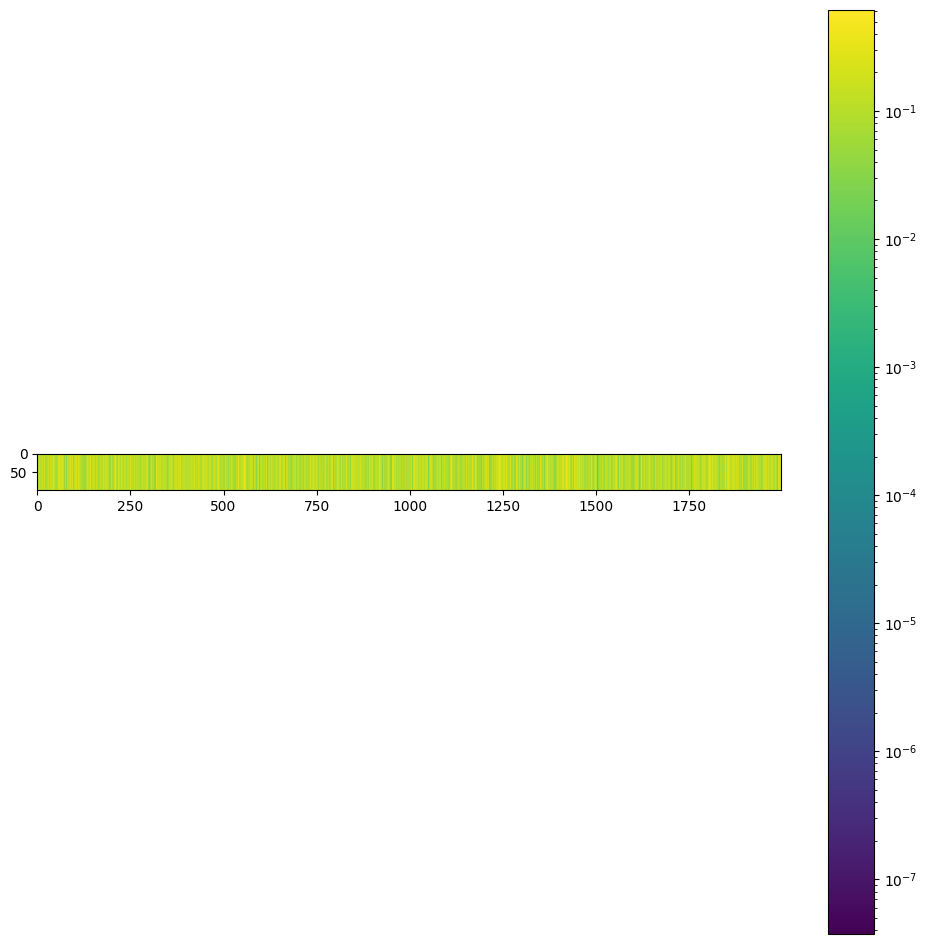

In [138]:
dx = .1
dy = dx

ypred_vx = outputs[:,:,:,0].permute(0,2,1)
ypred_vy = outputs[:,:,:,1].permute(0,2,1)

ytrue_vx = labels[:,:,:,0].permute(0,2,1)
ytrue_vy = labels[:,:,:,1].permute(0,2,1)

y_pred_div = calculate_divergence(ypred_vx, ypred_vy, dx, dy)
y_true_div = calculate_divergence(ytrue_vx, ytrue_vy, dx, dy)
plt.figure(figsize=(12,12))
plt.imshow(np.abs(y_pred_div.cpu().detach().numpy()[50,:,:]), norm=LogNorm())
plt.colorbar()

In [11]:
# Assuming you have a CustomDataset class
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR


class CustomDataset(Dataset):
    def __init__(self, x, target):
        """
        Args:
            data (numpy array): A numpy array of shape [N, 100, 200, 19] where N is the number of samples.
        """
        self.x = torch.tensor(x, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        input = self.x[idx]
        target = self.target[idx]
        return input, target

from sklearn.preprocessing import StandardScaler

#scalerx = StandardScaler()
#scalery = StandardScaler()

#x_scaled = scalerx.fit_transform(x.reshape(1, -1))
#y_scaled = scalery.fit_transform(y.reshape(1 -1))

criterion3 = SmoothnessLoss(.1, .1)
dataset = CustomDataset(x, y)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=100, n_classes=9).to(device)
criterion1 = DivLoss()
criterion2 = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
gamma = 0.99998  # The exponential decay factor (adjust as needed)
scheduler = ExponentialLR(optimizer, gamma=gamma)
#import gc

# Training loop
num_epochs = 40000
for epoch in range(num_epochs):
    model.train()
    for batch in dataloader:
        inputs = batch[0].to(device)
        labels = batch[1].to(device)
        labels = labels[0,:,:,:,:].permute(0,2,1,3)
        optimizer.zero_grad()
        outputs = model(inputs)
         # Assuming you want to compare against the input
        loss2 = criterion2(outputs, labels)
        if epoch < 3000:
            loss1 = criterion1(outputs, labels) 
            loss3 = criterion3(outputs)
            loss = (.2*loss1+loss2*2 + .000000002*loss3)/3
        else:
            loss1 = criterion1(outputs, labels) 
            loss = loss2+.001*loss1
        loss.backward()
        optimizer.step()
        scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Learning Rate: {current_lr:.6f}")



Epoch 1/40000, Loss: 0.06273537874221802, Learning Rate: 0.002000
Epoch 2/40000, Loss: 0.09435981512069702, Learning Rate: 0.002000
Epoch 3/40000, Loss: 0.04889047145843506, Learning Rate: 0.001999
Epoch 4/40000, Loss: 0.04934140667319298, Learning Rate: 0.001999
Epoch 5/40000, Loss: 0.0368013009428978, Learning Rate: 0.001999
Epoch 6/40000, Loss: 0.043831076472997665, Learning Rate: 0.001999
Epoch 7/40000, Loss: 0.034796375781297684, Learning Rate: 0.001998
Epoch 8/40000, Loss: 0.026932083070278168, Learning Rate: 0.001998
Epoch 9/40000, Loss: 0.030524227768182755, Learning Rate: 0.001998
Epoch 10/40000, Loss: 0.026211276650428772, Learning Rate: 0.001998
Epoch 11/40000, Loss: 0.024436693638563156, Learning Rate: 0.001997
Epoch 12/40000, Loss: 0.020341766998171806, Learning Rate: 0.001997
Epoch 13/40000, Loss: 0.021008726209402084, Learning Rate: 0.001997
Epoch 14/40000, Loss: 0.02424204722046852, Learning Rate: 0.001997
Epoch 15/40000, Loss: 0.021023984998464584, Learning Rate: 0.001

KeyboardInterrupt: 

In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.0015)
gamma = 0.99994  # The exponential decay factor (adjust as needed)
scheduler = ExponentialLR(optimizer, gamma=gamma)
#import gc

# Training loop
num_epochs = 30000
for epoch in range(num_epochs):
    model.train()
    for batch in dataloader:
        inputs = batch[0].to(device)
        labels = batch[1].to(device)
        labels = labels[0,:,:,:,:].permute(0,2,1,3)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss1 = criterion1(outputs, labels)  # Assuming you want to compare against the input
        loss2 = criterion2(outputs, labels)
        loss3 = criterion3(outputs)
        loss = (loss1*.1+loss2*2 + .000000001*loss3)/3
        loss.backward()
        optimizer.step()
        scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Learning Rate: {current_lr:.6f}")

Epoch 1/30000, Loss: 0.004004552029073238, Learning Rate: 0.001499
Epoch 2/30000, Loss: 0.0028416288550943136, Learning Rate: 0.001499
Epoch 3/30000, Loss: 0.0023865848779678345, Learning Rate: 0.001498
Epoch 4/30000, Loss: 0.0015171573031693697, Learning Rate: 0.001498
Epoch 5/30000, Loss: 0.0012848193291574717, Learning Rate: 0.001497
Epoch 6/30000, Loss: 0.0014545870944857597, Learning Rate: 0.001497
Epoch 7/30000, Loss: 0.0013269478222355247, Learning Rate: 0.001496
Epoch 8/30000, Loss: 0.0009922620374709368, Learning Rate: 0.001496
Epoch 9/30000, Loss: 0.0008938167011365294, Learning Rate: 0.001495
Epoch 10/30000, Loss: 0.0011773461010307074, Learning Rate: 0.001495
Epoch 11/30000, Loss: 0.0009026917978189886, Learning Rate: 0.001494
Epoch 12/30000, Loss: 0.0008649174124002457, Learning Rate: 0.001494
Epoch 13/30000, Loss: 0.0009419328416697681, Learning Rate: 0.001493
Epoch 14/30000, Loss: 0.0008815083419904113, Learning Rate: 0.001492
Epoch 15/30000, Loss: 0.001176426187157631, 

KeyboardInterrupt: 

In [58]:
criterion = DivLoss()#nn.MSELoss()

criterion(outputs, labels)

tensor([[[5.1564e-01, 7.5727e+00, 1.9868e+00,  ..., 1.2030e+00,
          1.9212e+00, 3.3515e+00],
         [2.5637e+00, 4.9511e+00, 1.4656e+00,  ..., 3.0131e+00,
          1.0168e+00, 1.2437e-01],
         [8.9360e+00, 3.0648e+00, 2.8402e-01,  ..., 1.1690e+00,
          5.0334e+00, 1.2699e+00],
         ...,
         [7.2156e-01, 1.2304e+01, 7.2504e-01,  ..., 3.0731e+00,
          6.1458e+00, 1.2223e+00],
         [2.5950e+00, 9.8888e+00, 4.5590e-01,  ..., 1.0342e+00,
          3.0683e+00, 5.5829e+00],
         [8.3886e+00, 3.4954e+00, 6.3353e-01,  ..., 5.3532e+00,
          6.7952e-01, 2.7545e+00]],

        [[7.8363e-02, 2.1410e-01, 1.9664e-01,  ..., 4.7573e-01,
          2.1009e+00, 5.4924e-01],
         [2.0668e+00, 1.8194e+00, 5.1937e-02,  ..., 6.8751e-02,
          3.3102e+00, 3.2211e-01],
         [1.0261e+00, 1.3700e+00, 1.0835e+00,  ..., 1.6150e+00,
          2.1300e+00, 2.0785e+00],
         ...,
         [1.1075e+00, 1.5402e+00, 7.4922e-01,  ..., 7.0519e-01,
          1.194

In [39]:
labels[10,:,:,1]

tensor([[-3.7364e+02, -2.1648e+02, -1.4755e+02,  ..., -2.7043e-02,
         -8.6548e-03, -2.8033e-03],
        [-1.0891e+02, -1.2843e+02, -1.1331e+02,  ..., -2.6677e-02,
         -8.5409e-03, -2.7707e-03],
        [-4.0432e+01, -7.3445e+01, -7.9750e+01,  ..., -2.5797e-02,
         -8.2954e-03, -2.7144e-03],
        ...,
        [ 7.5987e+00,  1.3356e+01,  1.4123e+01,  ..., -1.0619e-01,
         -1.0559e-01, -6.2215e-02],
        [ 2.0840e+01,  2.3782e+01,  2.0323e+01,  ..., -1.6030e-01,
         -1.9801e-01, -1.7920e-01],
        [ 7.2317e+01,  4.0696e+01,  2.6776e+01,  ..., -2.1897e-01,
         -3.5306e-01, -6.4454e-01]], device='cuda:0')

In [ ]:
num_epochs = 30000

dataset = CustomDataset(x, y)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
from torch.optim.lr_scheduler import ExponentialLR

# Model, loss, and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0012)
gamma = 0.99995  # The exponential decay factor (adjust as needed)
scheduler = ExponentialLR(optimizer, gamma=gamma)

for epoch in range(num_epochs):
    model.train()
    for batch in dataloader:
        inputs = batch[0].to(device)
        labels = batch[1].to(device)
        labels = labels[0,:,:,:,:].permute(0,2,1,3)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Assuming you want to compare against the input
        loss.backward()
        optimizer.step()
        scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Print the current learning rate    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Learning Rate: {current_lr:.6f}")


In [30]:
with h5py.File(h5_files[0], 'r') as file:
    for name in file:
        #if isinstance(file[name], h5py.Group):
        print(file[name])

<HDF5 group "/Coordinates" (3 members)>
<HDF5 group "/Provenance" (2 members)>
<HDF5 group "/Time:  0.00000E+00 h" (19 members)>
<HDF5 group "/Time:  1.00800E+03 h" (19 members)>
<HDF5 group "/Time:  1.05600E+03 h" (19 members)>
<HDF5 group "/Time:  1.10400E+03 h" (19 members)>
<HDF5 group "/Time:  1.15200E+03 h" (19 members)>
<HDF5 group "/Time:  1.20000E+03 h" (19 members)>
<HDF5 group "/Time:  1.24800E+03 h" (19 members)>
<HDF5 group "/Time:  1.29600E+03 h" (19 members)>
<HDF5 group "/Time:  1.34400E+03 h" (19 members)>
<HDF5 group "/Time:  1.39200E+03 h" (19 members)>
<HDF5 group "/Time:  1.44000E+02 h" (19 members)>
<HDF5 group "/Time:  1.44000E+03 h" (19 members)>
<HDF5 group "/Time:  1.48800E+03 h" (19 members)>
<HDF5 group "/Time:  1.53600E+03 h" (19 members)>
<HDF5 group "/Time:  1.58400E+03 h" (19 members)>
<HDF5 group "/Time:  1.63200E+03 h" (19 members)>
<HDF5 group "/Time:  1.68000E+03 h" (19 members)>
<HDF5 group "/Time:  1.72800E+03 h" (19 members)>
<HDF5 group "/Time:  

In [39]:
torch.save(model.state_dict(), 'model_weights4')

0.0005832184 0.0033241045


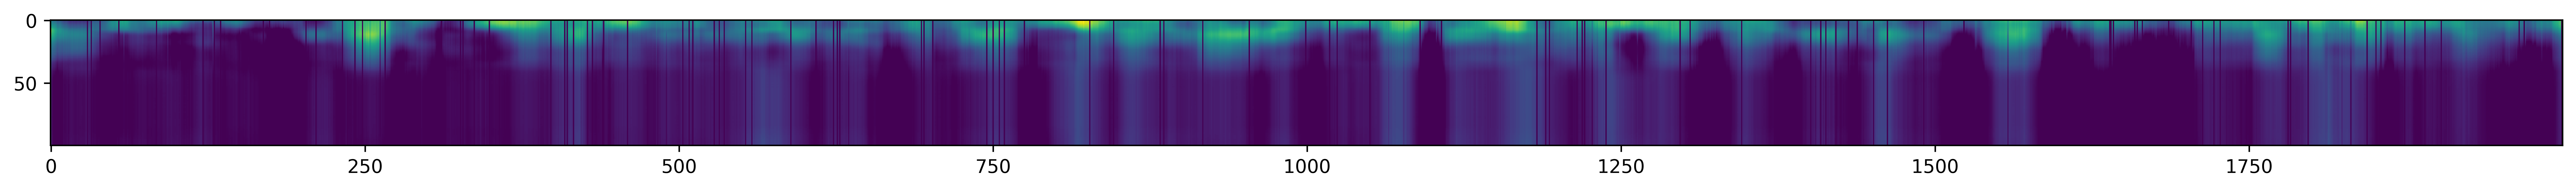

In [56]:
n=6
out = outputs5[100,:,:,n].permute(1,0).cpu().detach().numpy()
out[out<=0] = np.min(out[out>0])
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(24,24), dpi=600)
plt.imshow(out)#, norm=LogNorm(.0001,.5))
#plt.imshow(inputs[0,100,:,:,n].cpu().detach().numpy())
#fig.savefig('label.png')  # Replace 'output.png' with your desired file path and format

field_names[n]
#plt.colorbar()

orig_error = np.abs(np.mean(inputs[0,:,:,:,n].cpu().detach().numpy()) - np.mean(labels[:,:,:,n].cpu().detach().numpy()))

nn_error = np.abs(np.mean(outputs5[:,:,:,n].cpu().detach().numpy()) - np.mean(labels[:,:,:,n].cpu().detach().numpy()))
print (orig_error, nn_error)

In [58]:
np.max(out)

0.14821875

In [37]:
# Number of time steps and features to extract
#file_path = '/mnt/data/high_losing_42_11_1xscale.h5'
import h5py
import cv2
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

base_dir = '/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/'
f_dir = os.listdir(base_dir)
h5_files = []
h5_files_train = []

# Iterate over all files in the directory
for filename in f_dir:
    if (filename.endswith(".h5")) & ((("2x" in filename))):
        h5_files_train.append(base_dir+filename)
#     if (filename.endswith(".h5")) & (("8x" in filename)):
#         if (("10_5" not in filename) & ("20_20" not in filename)):
#             h5_files_train.append(base_dir+filename)
    if (filename.endswith(".h5")) & ((("10x" in filename))):
#         if (("10_5" in filename) | ("20_20" in filename)):
        h5_files.append(base_dir+filename)
# Run the processing in parallel
h5_files_train =  sorted(
    h5_files_train,
    key=lambda x: tuple(map(int, x.split('high_losing_')[1].split('_')[:2]))
)
h5_files =  sorted(
    h5_files,
    key=lambda x: tuple(map(int, x.split('high_losing_')[1].split('_')[:2]))
)

h5_files_test = h5_files[20:21]
h5_files_train_test = h5_files_train[20:21]
hdf5_file = h5py.File(h5_files_test[0], 'r')
# Fetching the first five time steps
time_steps = sorted(list(hdf5_file.keys()))

# Inspecting the features present in each of these time steps
features_per_time_step = {time_step: list(hdf5_file[time_step].keys()) for time_step in time_steps}


num_time_steps = 115
num_features = 9  # As observed from the dataset

# Initialize the final array with the desired shape [5, 100, 200, 19]
y_test = np.zeros((len(h5_files_test),num_time_steps-1, 100, 2000, num_features))

# Extracting and reshaping data from the first five time steps
for i in range(len(h5_files_test)):
    hdf5_file = h5py.File(h5_files_test[i], 'r')
    for t_idx, time_step in enumerate(time_steps[2:]):  # Skipping the first two non-time-step groups
        count=0
        for f_idx, feature in enumerate(features_per_time_step[time_step]):
            if ('O2' not in feature)& ('Perm' not in feature)& ('Material' not in feature)& ('Sat' not in feature)& ('Z' not in feature)& ('biocide' not in feature)& ('ethanol' not in feature)& ('Chubbite' not in feature):
                dataset = hdf5_file[time_step][feature]
                y_test[i, t_idx, :, :, count] = dataset[:, :, 0]#cv2.resize(dataset[:, :, 0], [500,50])  # Reshape and assign
                count = count+1

# Checking the shape of the extracted data array


x_test = np.zeros((len(h5_files_train_test),num_time_steps-1, 100, 400, num_features))

# Extracting and reshaping data from the first five time steps
for i in range(len(h5_files_train_test)):
    hdf5_file = h5py.File(h5_files_train_test[i], 'r')
    for t_idx, time_step in enumerate(time_steps[2:]):  # Skipping the first two non-time-step groups
        count=0
        for f_idx, feature in enumerate(features_per_time_step[time_step]):
            if ('O2' not in feature)& ('Perm' not in feature)& ('Material' not in feature)& ('Sat' not in feature)& ('Z' not in feature)& ('biocide' not in feature)& ('ethanol' not in feature)& ('Chubbite' not in feature):
                dataset = hdf5_file[time_step][feature]
                x_test[i, t_idx, :, :, count] = dataset[:, :, 0]#cv2.resize(dataset[:, :, 0], [500,50])  # Reshape and assign
                count = count+1

In [38]:
#torch.save(model, 'model')
#torch.save(model.state_dict(), 'model_weights2')
x_test.shape


(1, 114, 100, 400, 9)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(n_channels=100, n_classes=9).to(device)


In [9]:
model_weights_path = 'model_weights4'

# Load the model's state dictionary (weights)
model.load_state_dict(torch.load(model_weights_path))
model

UNet(
  (up): DoubleConv_up(
    (double_conv): Sequential(
      (0): Conv2d(400, 600, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(600, 800, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(800, 1200, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU(inplace=True)
    )
  )
  (outc): Conv2d(1200, 2000, kernel_size=(1, 1), stride=(1, 1))
)

In [10]:
scales=[[-3.8411125549317013, 597.4671440974266],
 [-615.1042997637863, 357.84820748247256],
 [0.0, 6822.169871757096],
 [0.0001, 0.6],
 [7.788525219135888, 15.024872883573318],
 [9.998195511764697e-21, 0.0021615209557147423],
 [9.992418077905442e-21, 0.00019222389277486797],
 [1e-10, 353.88041919640534],
 [9.999999999999992e-21, 4.945182939521276]]
scales

[[-3.8411125549317013, 597.4671440974266],
 [-615.1042997637863, 357.84820748247256],
 [0.0, 6822.169871757096],
 [0.0001, 0.6],
 [7.788525219135888, 15.024872883573318],
 [9.998195511764697e-21, 0.0021615209557147423],
 [9.992418077905442e-21, 0.00019222389277486797],
 [1e-10, 353.88041919640534],
 [9.999999999999992e-21, 4.945182939521276]]

In [39]:
for i in range(x_test.shape[4]):
    xmin = scales[i][0]
    xmax = scales[i][1]
    x_test[:,:,:,:,i] = (x_test[:,:,:,:,i] - xmin)/(xmax-xmin)
    y_test[:,:,:,:,i] = (y_test[:,:,:,:,i] - xmin)/(xmax-xmin)
    #scales.append([xmin,xmax])
y_test[0,100,0,:,7]

array([0.01872465, 0.05613483, 0.08445839, ..., 0.24322912, 0.19144413,
       0.12252723])

In [40]:
test_dataset = CustomDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Adjust batch size as needed

# Define a loss function if needed (e.g., for validation)
criterion = nn.MSELoss()  # Replace with your loss function if needed

# Lists to store predictions and true labels
all_predictions = []
all_true_labels = []

model.eval()
# Iterate through the test data
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels[0,:,:,:,:].permute(0,2,1,3)
        # Forward pass
        outputs = model(inputs)
        # If you have a loss function, compute the loss (optional)
        loss = criterion(outputs, labels)
        print (loss)


# Calculate accuracy (or other evaluation metrics)


tensor(0.0132, device='cuda:0')


'Liquid X-Velocity [m_per_h]'

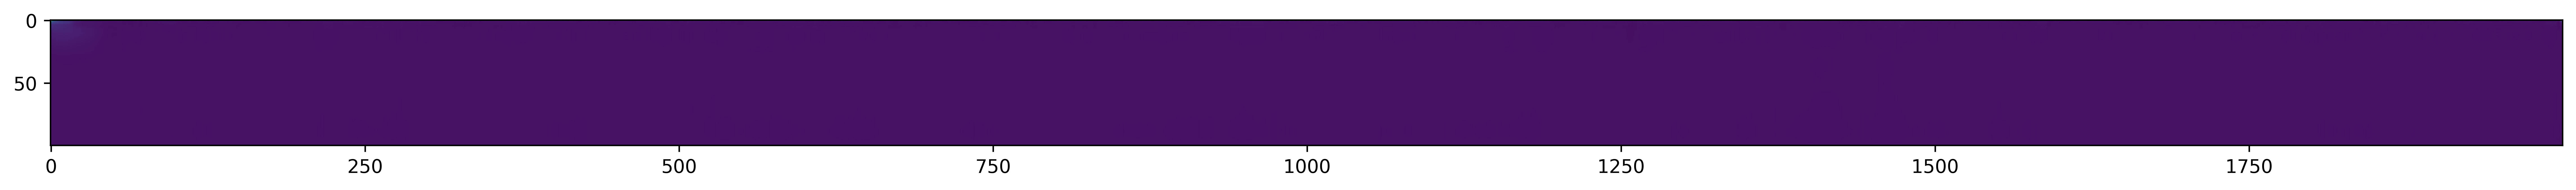

In [53]:
n=0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(24,24), dpi=600)
val = outputs[100,:,:,n].permute(1,0).cpu().detach().numpy()
plt.imshow(val)
#plt.imshow(inputs[0,100,:,:,n].cpu().detach().numpy())
#fig.savefig('label_test.png')  # Replace 'output.png' with your desired file path and format

field_names[n]

In [52]:
n=0

orig_error = np.abs(np.mean(inputs[0,:,:,:,n].cpu().detach().numpy()) - np.mean(labels[:,:,:,n].cpu().detach().numpy()))

nn_error = np.abs(np.mean(outputs[:,:,:,n].cpu().detach().numpy()) - np.mean(labels[:,:,:,n].cpu().detach().numpy()))
print (orig_error, nn_error)

0.0002691159 0.00015786244


In [54]:
print (orig_error, nn_error)

0.00018337276 0.00024984404


In [6]:
scales=[[-3.8411125549317013, 597.4671440974266],
 [-615.1042997637863, 357.84820748247256],
 [0.0, 6822.169871757096],
 [0.0001, 0.6],
 [7.788525219135888, 15.024872883573318],
 [9.998195511764697e-21, 0.0021615209557147423],
 [9.992418077905442e-21, 0.00019222389277486797],
 [1e-10, 353.88041919640534],
 [9.999999999999992e-21, 4.945182939521276]]
scales

[[-12.696747371716862, 674.760452763084],
 [-674.7761220066308, 357.84820748247256],
 [0.0, 6822.169871757096],
 [0.0001, 0.6],
 [5.788525614365926, 15.024872883573318],
 [9.998195511764697e-21, 0.0021615209557147423],
 [9.992418077905442e-21, 0.0018179349917678152],
 [1e-10, 353.88041919640534],
 [9.999999999999992e-21, 8.902117136738323]]

In [1]:
import numpy as np

def calculate_divergence(vx, vy, dx, dy):
    """
    Calculate the divergence of a 2D velocity field using a forward-looking finite difference scheme.
    
    Parameters:
    vx: 2D array of velocity in the x-direction
    vy: 2D array of velocity in the y-direction
    dx: Grid spacing in the x-direction
    dy: Grid spacing in the y-direction
    
    Returns:
    divergence: 2D array of divergence values
    """
    # Get the dimensions of the velocity field
    rows, cols = vx.shape

    # Initialize an array to store divergence
    divergence = np.zeros((rows, cols))

    # Calculate divergence using forward differences
    # For the edges, we use backward differences to avoid index out of range
    for i in range(rows):
        for j in range(cols):
            dvx_dx = (vx[i, min(j+1, cols-1)] - vx[i, j]) / dx
            dvy_dy = (vy[min(i+1, rows-1), j] - vy[i, j]) / dy
            divergence[i, j] = dvx_dx + dvy_dy

    return divergence

# Example usage with dummy data
# Create sample velocity fields
#vx = outputs[100,:,:,0].permute(1,0).cpu().detach().numpy()

#vy = outputs[100,:,:,1].permute(1,0).cpu().detach().numpy()


# Assume uniform grid spacing
#dx = 1  # x-spacing
#dy = 1  # y-spacing

# Calculate divergence
#divergence = calculate_divergence(vx, vy, dx, dy)
#divergence


In [51]:
mse=nn.MSELoss()

In [52]:
mse(1,1)

AttributeError: 'int' object has no attribute 'size'

In [26]:
scales_train=[]
for i in h5_files_train:
    if 'high_gaining' in i:
        scales_train.append(i.split('_')[7][0])
    else:
        scales_train.append(i.split('_')[6][0])
    
scales=[]
for i in h5_files:
    if 'high_gaining' in i:
        scales.append(i.split('_')[7][0])
    else:
        scales.append(i.split('_')[6][0])
scales

['1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1']

In [27]:
import h5py
import cv2

base_dir = '/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/'
f_dir = os.listdir(base_dir)
h5_files = []
h5_files_train = []

# Iterate over all files in the directory
for filename in f_dir:
    if (filename.endswith(".h5")) & ((("2x" in filename))):
        h5_files_train.append(base_dir+filename)
#     if (filename.endswith(".h5")) & (("8x" in filename)):
#         if (("10_5" not in filename) & ("20_20" not in filename)):
#             h5_files_train.append(base_dir+filename)
    if (filename.endswith(".h5")) & ((("10x" in filename))):
#         if (("10_5" in filename) | ("20_20" in filename)):
        h5_files.append(base_dir+filename)
# Run the processing in parallel
h5_files_train =  sorted(
    h5_files_train,
    key=lambda x: tuple(map(int, x.split('high_losing_')[1].split('_')[:2]))
)
h5_files =  sorted(
    h5_files,
    key=lambda x: tuple(map(int, x.split('high_losing_')[1].split('_')[:2]))
)

perm_covar=[]
for i in h5_files_train:
    if 'high_gaining' in i:
        perm_covar.append(int(i.split('_')[5])/int(i.split('_')[6]))
    else:
        perm_covar.append(int(i.split('_')[4])/int(i.split('_')[5]))
perm_covar    

[1.4,
 0.7727272727272727,
 1.8,
 0.9473684210526315,
 1.375,
 1.411764705882353,
 1.6666666666666667,
 1.625,
 3.857142857142857,
 3.375,
 1.9285714285714286,
 3.2222222222222223,
 2.0,
 4.428571428571429,
 5.666666666666667,
 2.2666666666666666,
 1.619047619047619,
 5.0,
 1.5217391304347827,
 3.272727272727273,
 2.0,
 4.111111111111111,
 2.375,
 3.9,
 3.0,
 5.0,
 2.3529411764705883,
 2.0,
 3.4166666666666665,
 2.411764705882353,
 2.05,
 3.8181818181818183,
 5.0,
 2.3684210526315788,
 5.111111111111111,
 4.6,
 2.7058823529411766,
 5.222222222222222,
 4.9,
 2.5789473684210527,
 2.0416666666666665,
 5.0,
 5.1,
 6.5,
 5.888888888888889,
 7.125]

In [28]:
max_l=[]
for i in h5_files_train:
    if 'high_gaining' in i:
        max_l.append(np.max([int(i.split('_')[5]),int(i.split('_')[6])]))
    else:
        max_l.append(np.max([int(i.split('_')[4]),int(i.split('_')[5])]))
max_l  

[14,
 22,
 18,
 19,
 22,
 24,
 25,
 26,
 27,
 27,
 27,
 29,
 30,
 31,
 34,
 34,
 34,
 35,
 35,
 36,
 36,
 37,
 38,
 39,
 39,
 40,
 40,
 40,
 41,
 41,
 41,
 42,
 45,
 45,
 46,
 46,
 46,
 47,
 49,
 49,
 49,
 50,
 51,
 52,
 53,
 57]

In [29]:
growth_rates=[]
rate_c=[]
rate_d=[]
exp_b = []
for i in range(len(h5_files)):
    file_path = h5_files[i][:-3]+'.in'
    #print (file_path)
    with open(file_path, 'r') as file:
        lines = file.readlines()
    gr = float(lines[79].split()[1].replace('d', 'e'))
    c = float(lines[81].split()[1].replace('d', 'e'))
    d = float(lines[94].split()[1].replace('d', 'e'))
    b = float(lines[65].split()[1])
    growth_rates.append(gr)
    rate_c.append(c)
    rate_d.append(d)
    exp_b.append(b)

In [ ]:


tags =[rate_c, rate_d, exp_b, max_l, perm_covar, growth_rates]
count=0
tag_scales = []
for i in tags:
    xmax = np.max(i)
    xmin = np.min(i)
    tags[count] = (i-xmin)/(xmax-xmin)
    tag_scales.append([xmin, xmax])
    count = count+1


In [ ]:
tags_small = np.zeros([6,114,100,400,1)
for i in range(len(h5_files)):
    tags_small[i,:,0:16, :, :] = torch.full((1,114,16,400,1),tags[0][i])
    tags_small[i,:,16:32, :, :] = torch.full((1,114,16,400,1),tags[1][i])
    tags_small[i,:,32:48, :, :] = torch.full((1,114,16,400,1),tags[2][i])
    tags_small[i,:,48:64, :, :] = torch.full((1,114,16,400,1),tags[3][i])
    tags_small[i,:,64:80, :, :] = torch.full((1,114,16,400,1),tags[4][i])
    tags_small[i,:,80:, :, :] = torch.full((1,114,16,400,1),tags[5][i])

tags_big = torch.copy(tags_small)
#torch.concat(x,tags_small)

In [30]:
for i in range(len(dfs)):
    print (i,len(dfs_train[i]))

0 110
1 110
2 110
3 110
4 110
5 110
6 110
7 110
8 110
9 110
10 110
11 110
12 110
13 110
14 110
15 110
16 110
17 110
18 110
19 110
20 110
21 110
22 110
23 110
24 110
25 110
26 110
27 110
28 110
29 110
30 110
31 110
32 110
33 110
34 110
35 110
36 110
37 110
38 110
39 110
40 110
41 110
42 110
43 110
44 110
45 110


In [31]:
h5_files

['/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/high_losing_14_10_10xscale.h5',
 '/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/high_losing_17_22_10xscale.h5',
 '/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/high_losing_18_10_10xscale.h5',
 '/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/high_losing_18_19_10xscale.h5',
 '/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/high_losing_22_16_10xscale.h5',
 '/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/high_losing_24_17_10xscale.h5',
 '/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/high_losing_25_15_10xscale.h5',
 '/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/high_losing_26_16_10xscale.h5',
 '/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/high_losing_27_7_10xscale.h5',
 '/home/mbadhan/Desktop/mberghouse/PFLOTRAN/one_deeper/input_files/high_losing_27_8_10xscale.h5',
 '/home/mbad

In [32]:
import numpy as np
for i in range(len(dfs)):
    #rate b_1 (growth rate)
    #rate_c
    #exp_b
    #rate d_1 (carbon reuse)
    dfs[i]['sim_id']=i
    #dfs[i]['scale']=scales[i]
   # if 'gaining' in h5_files[i]:
   #     dfs[i]['type_id']=0
   # if 'high_gaining' in h5_files[i]:
   #     dfs[i]['type_id']=1
   # if 'losing' in h5_files[i]:
   #     dfs[i]['type_id']=2
   # if 'highlosing' in h5_files[i]:
   #     dfs[i]['type_id']=3
    dfs[i]['perm_covar']=perm_covar[i]
    dfs[i]['max_l']=max_l[i]
    perm_values = dfs[i]["Permeability_X [m^2]"].values
    if perm_covar[i]>1:
        k_eff =np.mean(perm_values.size / np.sum(1.0 / perm_values))
    else:
        k_eff = np.mean(perm_values)

    #dfs[i]['k_eff']=k_eff
    dfs[i]['growth_rates']=growth_rates[i]
    dfs[i]['rate_c']=rate_c[i]
    dfs[i]['rate_d']=rate_d[i]
    dfs[i]['exp_b']=exp_b[i]

for i in range(len(dfs_train)):
    dfs_train[i]['sim_id']=i
    #dfs_train[i]['scale']=scales_train[i]
    #if 'gaining' in h5_files[i]:
    #    dfs_train[i]['type_id']=0
    #if 'high_gaining' in h5_files[i]:
        #print (i[1].fname)
    #    dfs_train[i]['type_id']=1
    #if 'losing' in h5_files[i]:
    #    dfs_train[i]['type_id']=2
    #if 'highlosing' in h5_files[i]:
    #    dfs_train[i]['type_id']=3
#     if i >= 33:
#         dfs[i]['sim_id']=4
#     dfs[i]['sim_id2']=i
    
    dfs_train[i]['perm_covar']=perm_covar[i]
#     dfs[i]['gaining']=gaining[i]
#     dfs[i]['losing']=losing[i]
    dfs_train[i]['max_l']=max_l[i]
    #dfs[i]['NL']=NL[i]
    perm_values = dfs_train[i]["Permeability_X [m^2]"].values
    #if perm_covar[i]>1:
    #    k_eff =np.mean(perm_values.size / np.sum(1.0 / perm_values))
    #else:
    #    k_eff = np.mean(perm_values)

    #dfs_train[i]['k_eff']=k_eff
    #dfs_train[i]['k_eff']=k_eff
    dfs_train[i]['growth_rates']=growth_rates[i]
    dfs_train[i]['rate_c']=rate_c[i]
    dfs_train[i]['rate_d']=rate_d[i]
    dfs_train[i]['exp_b']=exp_b[i]
    

combined_df = pd.concat(dfs)
combined_df_train = pd.concat(dfs_train)
combined_df
final_data = np.array(combined_df)
final_data_train = np.array(combined_df_train)
x = np.delete(final_data_train, [1,2,5,7,8,15,16], 1)
target = np.delete(final_data, [1,2,5,7,8,15,16], 1)
 
#x_test = np.delete(final_data_train, [1,2,5,7,8,14,15,16,19], 1)
# #target = np.delete(final_data, [1,2,5,7,8,14,15,16,19], 1)
# #x = np.delete(final_data, [3, 5, 6, 11, 12, 13, 16,17,18,19], 1)
# y_train = final_data_train[:, 13]
# y_test = final_data[:, 13]
print (x.shape, target.shape)

(5060, 20) (5060, 20)


In [33]:
dfs_train[0].iloc[1,9:]


Permeability_X [m^2]     2.445674e-10
Porosity                 1.584149e-01
Temperature [C]          8.961414e+00
Total_CO2 [M]            9.948697e-05
Total_Cr(VI) [M]         3.894979e-06
Total_O2 [M]             4.999970e+02
Total_biocide [M]        9.999972e-11
Total_ethanol [M]        9.999972e-11
Total_molasses [M]       2.270490e-06
biomass [mol_m^3]        9.441274e-07
molasses_im [mol_m^3]    5.220698e-02
sim_id                   0.000000e+00
perm_covar               1.400000e+00
max_l                    1.400000e+01
growth_rates             1.363760e-05
rate_c                   3.170410e-09
rate_d                   1.000000e-01
exp_b                    2.659390e+00
Name: 32, dtype: float64

In [34]:
dfs_train[0]

,Time,Chubbite_Rate [mol_m^3_sec],Chubbite_VF [m^3 mnrl_m^3 bulk],Liquid X-Velocity [m_per_h],Liquid Y-Velocity [m_per_h],Liquid Z-Velocity [m_per_h],Liquid_Pressure [Pa],Liquid_Saturation,Material_ID,Permeability_X [m^2],...,Total_molasses [M],biomass [mol_m^3],molasses_im [mol_m^3],sim_id,perm_covar,max_l,growth_rates,rate_c,rate_d,exp_b
21,192.0,0.0,0.841585,0.877140,-0.010643,0.0,1552.525408,0.985904,1.0,2.445674e-10,...,2.223517e-06,2.343395e-07,0.051616,0,1.4,14,0.000014,3.170410e-09,0.1,2.65939
32,240.0,0.0,0.841585,0.709446,-0.010747,0.0,1261.106711,0.985849,1.0,2.445674e-10,...,2.270490e-06,9.441274e-07,0.052207,0,1.4,14,0.000014,3.170410e-09,0.1,2.65939
43,288.0,0.0,0.841585,0.877356,-0.010624,0.0,1556.111624,0.985905,1.0,2.445674e-10,...,2.240250e-06,3.781464e-06,0.051820,0,1.4,14,0.000014,3.170410e-09,0.1,2.65939
54,336.0,0.0,0.841585,1.036851,-0.010508,0.0,1836.479850,0.985958,1.0,2.445674e-10,...,2.217294e-06,1.500408e-05,0.051546,0,1.4,14,0.000014,3.170410e-09,0.1,2.65939
65,384.0,0.0,0.841585,1.154984,-0.010418,0.0,2044.741518,0.985997,1.0,2.445674e-10,...,2.208773e-06,5.906743e-05,0.051442,0,1.4,14,0.000014,3.170410e-09,0.1,2.65939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,5232.0,0.0,0.847638,1.190599,-0.013500,0.0,2186.936281,0.986024,1.0,2.352886e-10,...,5.506438e-07,6.144571e+01,0.014858,0,1.4,14,0.000014,3.170410e-09,0.1,2.65939
100,5280.0,0.0,0.847714,1.212166,-0.013330,0.0,2229.067466,0.986032,1.0,2.351712e-10,...,5.562375e-07,6.223035e+01,0.015085,0,1.4,14,0.000014,3.170410e-09,0.1,2.65939
101,5328.0,0.0,0.847790,1.182790,-0.013011,0.0,2178.777312,0.986022,1.0,2.350547e-10,...,5.539103e-07,6.299632e+01,0.015025,0,1.4,14,0.000014,3.170410e-09,0.1,2.65939
102,5376.0,0.0,0.847862,1.174133,-0.012771,0.0,2165.943470,0.986020,1.0,2.349423e-10,...,5.538787e-07,6.373198e+01,0.015017,0,1.4,14,0.000014,3.170410e-09,0.1,2.65939
